# Deep Learning for images

In previous lessons, we've worked extensively with **tabular data**—structured datasets where each row represents an observation and each column represents a feature. These datasets are typically easy to represent and analyze using tools like `pandas`, `scikit-learn`, and various statistical models.

However, **images** are fundamentally different in both structure and content. Instead of rows and columns of explicitly labeled features, an image is a grid of pixel values—typically in 2D for grayscale or 3D for color (height × width × channels). For example, a color image of size 224×224 pixels with 3 color channels (RGB) contains over 150,000 raw values, none of which are labeled with human-interpretable features like "age" or "income".

![DL 4 Img](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/3_what-is-deep-learning.png)


This difference leads to several important challenges:

- **High Dimensionality**: Images contain many more features (pixels) than typical tabular datasets, which increases computational complexity and the risk of overfitting.
- **Spatial Structure**: Nearby pixels in an image are often related, forming edges, textures, and patterns. Tabular models generally do not capture such local dependencies.
- **Semantic Gap**: The relationship between raw pixels and meaningful concepts (like a cat, a face, or a traffic sign) is complex and non-linear, requiring sophisticated models to bridge this gap.

Because of these challenges, we need **image-specific models**, most notably **Convolutional Neural Networks (CNNs)**, which are designed to exploit the spatial and hierarchical structure of images. These models learn to recognize patterns such as edges, shapes, and eventually objects, by processing images in layers of increasing abstraction.

In this module, we will explore how to work with image data, and why specialized techniques are crucial for tasks such as image classification, object detection, and image generation. To do so we will use again `PyTorch`.

## Batches

When training deep learning models with images, we don't feed the whole dataset, as we dit for tabular data. Instead, we group multiple images into **batches**.

A **batch** is a collection of samples (e.g., images and their labels) processed together in a single forward and backward pass.

### Why Batching?

- **Efficiency**: Batches make better use of GPU parallelism, speeding up training.
- **Memory Management**: Handling smaller groups instead of the full dataset helps manage limited GPU memory.
- **Gradient Stability**: Averaging gradients over a batch reduces noise in weight updates.

### Terminology

- **Batch Size**: The number of samples in a single batch (e.g., 32, 64, or 128). This is a key hyperparameter.
- **Epoch**: One complete pass through the entire dataset.
- **Iteration**: One update step; corresponds to processing one batch.

## The MNIST Dataset

To begin working with image data in practice, we'll use one of the most well-known benchmark datasets: **MNIST**.

**MNIST** stands for *Modified National Institute of Standards and Technology* database. It consists of **70,000 grayscale images** of handwritten digits (0 through 9), split into:

- **60,000 training images**
- **10,000 test images**

Each image is:

- **28 × 28 pixels**
- **Grayscale** (i.e., a single channel)
- **Labeled** with the correct digit (0–9)

This dataset is ideal for learning because it's small, clean, and already preprocessed, while still offering real-world complexity in handwritten digits.

### Example MNIST Images

Below is a sample of MNIST digits:

![MNIST Examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each row in the image above shows digits 0–9 written by different people. As you can see, some digits are written in very different ways, which is why we need machine learning to recognize them automatically.

We simplify the problem, making it a binary problem: **is a 5 or not?**

In [1]:
import numpy as np
from IPython.core.pylabtools import figsize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

/Users/miquelmn/miniconda3/envs/cursSocib/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

# Loop through batches
for images, labels in dataloader_train:
    print(images.shape)  # torch.Size([64, 3, 32, 32])
    break

torch.Size([64, 1, 28, 28])


In [4]:
mlp_net = nn.Sequential(
    torch.nn.Linear(784, 10),
    nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(10, 1)
)

In [5]:
EPOCHS = 5
loss_fn = nn.BCEWithLogitsLoss()
LR = 1e-3
optimizer = torch.optim.Adam(mlp_net.parameters(), lr=LR)

In [7]:

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Epochs"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 0
    for i_batch, (x, y) in enumerate(dataloader_train):  # We have to iter the batches.
        mlp_net.train()
        x = x.reshape(x.shape[0], -1)  # Flatten images

        optimizer.zero_grad()
        y_pred = mlp_net(x)

        # 1. LOSS CALCULATION
        y_binary = (y == 5)  # Simplification
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        # 2. GRADIENT
        mlp_net.zero_grad()
        loss.backward()

        # 3. OPTIMISATION
        with torch.no_grad():
            optimizer.step()

        # 4. EVALUATION
        mlp_net.eval()  # Mode avaluació de la xarxa

        y_pred = mlp_net(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y_binary.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))


Epochs: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


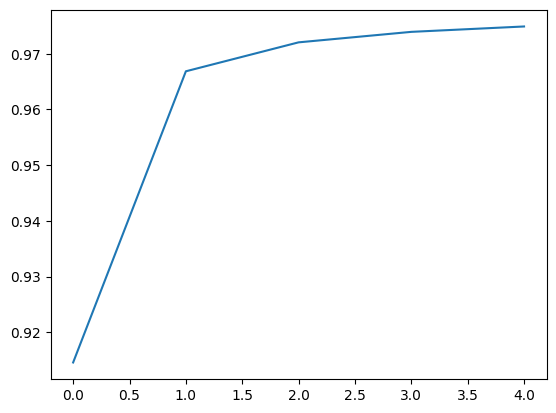

In [8]:
from matplotlib import pyplot as plt

plt.plot(running_acc);

## CNNs

Until now we have used MLP. In the previous example wa had to flatten the data. Therefore, happens the following:

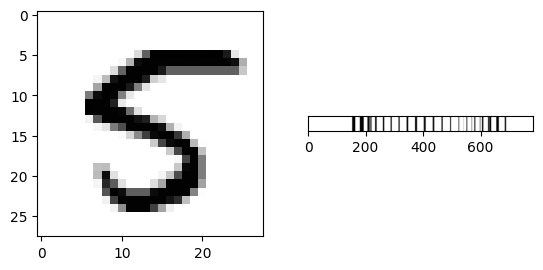

In [9]:
plt.subplot(1, 2, 1)
plt.imshow(images[0, 0], cmap="Greys")
plt.subplot(1, 2, 2)
plt.imshow(np.hstack(([images[0, 0].flatten()] * 50)).reshape(50, -1), cmap="Greys");  # To improve the width
plt.yticks([]);

As you can see it we make a complex problem even worse. For `MNIST` there is not problem. But for more complex images do you think it will be a problem?

Now that we’re working with image data like MNIST, we need models that can understand **spatial patterns** in images—such as edges, textures, and shapes. This is where **Convolutional Neural Networks (CNNs)** come in.

CNNs are a special class of neural networks designed specifically for processing **grid-like data**, such as images.

Unlike traditional fully connected networks, CNNs take advantage of the **2D structure** of images. They can recognize patterns that occur in small regions of an image and reuse that knowledge across the whole image.

They were first introduce in the 80s by [LeCun *et al.*](https://ieeexplore.ieee.org/abstract/document/6795724) alongside the `MNIST` dataset. A CNN has two main parts:

<img src="../assets/bloc2/cnn.png" width="500" />

The **convolutional** part and the classifier.

### Key Building Blocks of a CNN

1. **Convolutional Layers**. These layers apply **filters (or kernels)** that slide over the image to detect simple patterns like edges or corners. Each filter outputs a new image-like map called a **feature map**.

2. **Activation Function (ReLU)**. Non-linear activation (usually ReLU) is applied after each convolution to introduce non-linearity and help the network learn complex patterns.

3. **Pooling Layers**. These layers **downsample** the feature maps by summarizing small regions (e.g., taking the max value). Pooling helps reduce the spatial size and the number of parameters, making the model faster and more robust.

4. **Classifier**. We can use any machine learning model after the convolutional part. We usually use a MLP.

# Our first CNN

We will use a more complex dataset: [Sea Animals Image Dataset](https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste/data). We can find this dataset on Kaggle. Here the description:

> The dataset contains different images of marine animals. Some images were taken from pixabay.com and requires no license or attribution when used. Other images were taken from flickr.com where attribution to the original authors will be required when used commercially. Currently, there are 19 different classes available and may be extended further in the future. The images are resized to either (300px, n) or (n,300px) where n is a pixel size less than 300px. See the license and attribution agreements below if you are to use the images commercially.

To download the data we will use the `kagglehub` library.

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

Path to dataset files: /Users/miquelmn/.cache/kagglehub/datasets/vencerlanz09/sea-animals-image-dataste/versions/5


We will use as the `ImageFolder` class from `PyTorch` to handle the images.  from `torchvision.datasets`.

#### Folder Structure

The `ImageFolder` dataset assumes your images are arranged like this:

```
data/
├── train/
│   ├── class1/
│   │   ├── img001.jpg
│   │   ├── img002.jpg
│   ├── class2/
│   │   ├── img001.jpg
│   │   ├── img002.jpg
└── val/
    ├── class1/
    └── class2/
```

Each **subfolder** represents a class, and each image inside is a sample of that class. The class labels are automatically inferred from the folder names.


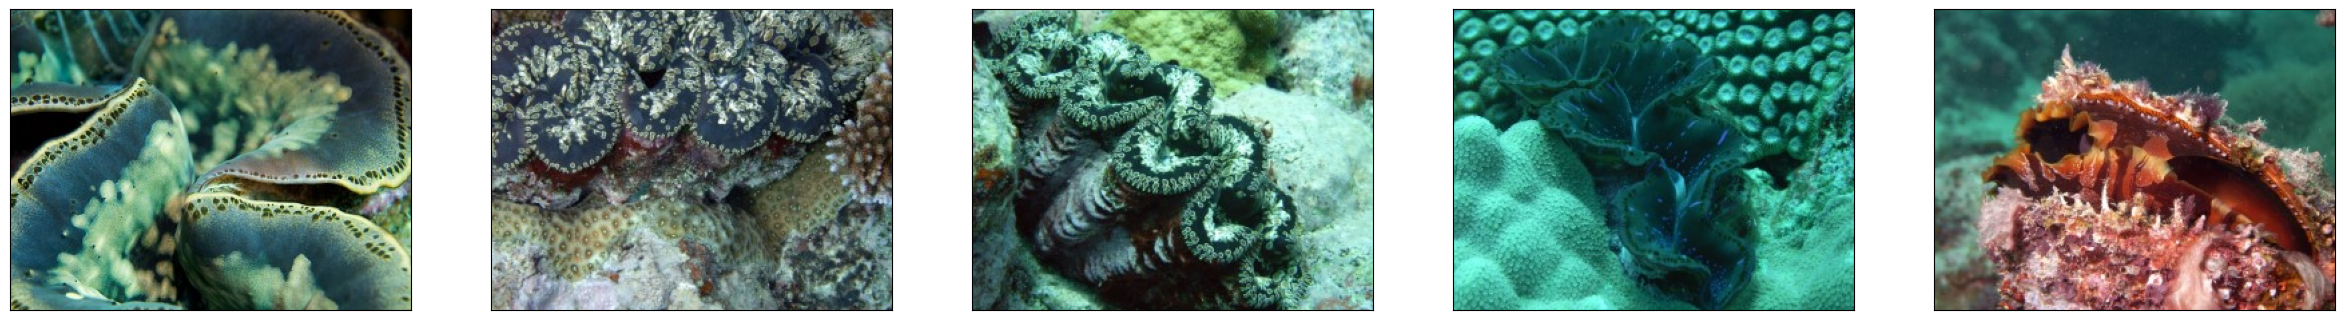

In [13]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

dataset = ImageFolder(path)

plt.figure(figsize=(30, 15))
for i, (image, label) in enumerate(dataset):
    plt.subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    if i == 4:
        break

To use the images we have to do a set of tasks:

1. Divide the dataset into train/validation.
2. Resize the images to have the same size.

In [14]:
BATCH_SIZE = 10
IMAGE_SIZE = (128, 128)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE),
])

dataset = ImageFolder(path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Division
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Once we have the data we must define the model. We will use the same approach than in the previous sessions.

In [32]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolucional
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=25,
            kernel_size=(3, 3),
            padding="same",
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(
            in_channels=25, out_channels=50, kernel_size=(3, 3), padding="same"
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Classifier
        self.fc1 = nn.Linear(in_features=32 * 32 * 50, out_features=25)  # 50
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=25, out_features=23)
        self.relu5 = nn.ReLU()

        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu4(x)

        x = self.fc2(x)
        x = self.relu5(x)

        return self.softmax(x)


In [ ]:
net = Net()

EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
LR = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=LR)


running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Epochs"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 0
    for i_batch, (x, y) in enumerate(dataloader_train):  # We have to iter the batches.
        net.train()

        optimizer.zero_grad()
        y_pred = net(x)

        loss = loss_fn(y_pred, y)

        net.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        net.eval()  # Mode avaluació de la xarxa

        y_pred = net(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y).detach())
        # batch_acc += accuracy_score(y_pred_binary.detach(), y.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    # running_acc.append(batch_acc / (i_batch + 1))
